In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from transformers import AutoTokenizer

In [10]:
#데이터를 df형태로 불러옴

#columns => ['id', 'source', 'sentence_1', 'sentence_2', 'label', 'binary-label']
#size => [9324rows x 6 columns, 550 rows x 6 columns]
train_df = pd.read_csv('train.csv')
dev_df = pd.read_csv('dev.csv')

#columns => ['id', 'source', 'sentence_1', 'sentence_2']
#size => [1100 rows x 4 columns]
test_df = pd.read_csv('test.csv')

***1. 데이터 분포조사***

연속적인 레이블(0-5 사이의 실수)과 이진 레이블(0 또는 1)의 분포를 조사.

이를 통해 데이터가 어떤 범위에 집중되어 있는지, 불균형이 있는지 파악.

In [11]:
#train과 dev의 label, binary label 통계분석
print(train_df.describe())
print(dev_df.describe())

             label  binary-label
count  9324.000000   9324.000000
mean      1.849968      0.389532
std       1.602212      0.487670
min       0.000000      0.000000
25%       0.200000      0.000000
50%       1.600000      0.000000
75%       3.400000      1.000000
max       5.000000      1.000000
            label  binary-label
count  550.000000    550.000000
mean     2.584000      0.520000
std      1.459483      0.500055
min      0.000000      0.000000
25%      1.400000      0.000000
50%      2.600000      1.000000
75%      3.800000      1.000000
max      5.000000      1.000000


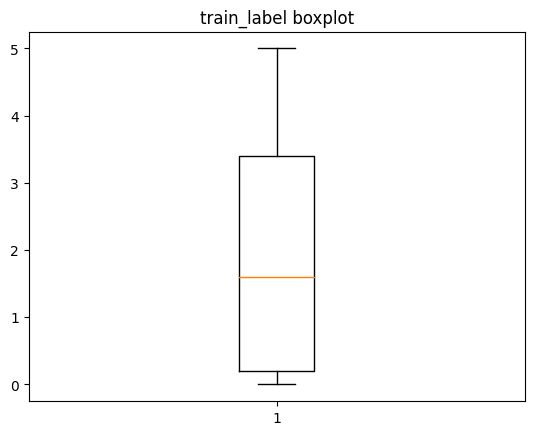

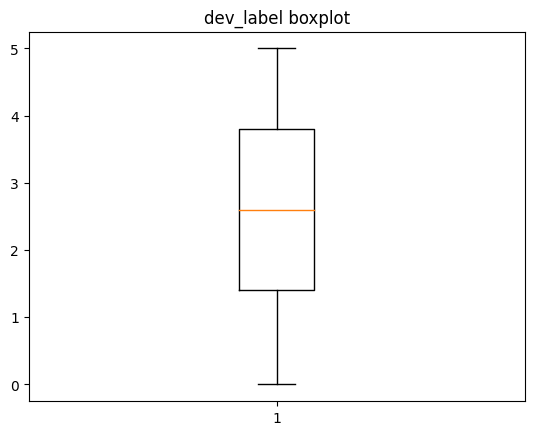

In [12]:
#train과 dev의 label의 분포를 box plot으로 그림
train_label_list = [row['label'] for idx, row in train_df.iterrows()]
dev_label_list = [row['label'] for idx, row in dev_df.iterrows()]

plt.boxplot(train_label_list)
plt.title("train_label boxplot")
plt.show()

plt.boxplot(dev_label_list)
plt.title("dev_label boxplot")
plt.show()

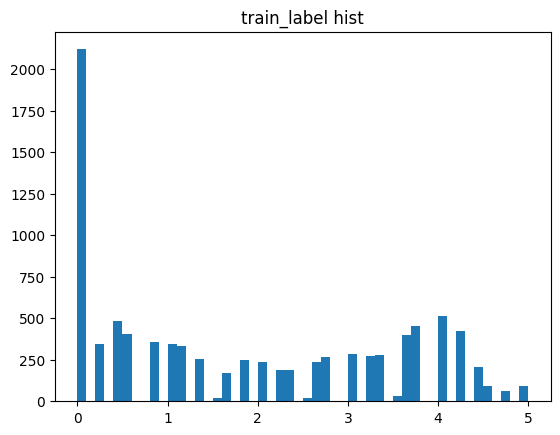

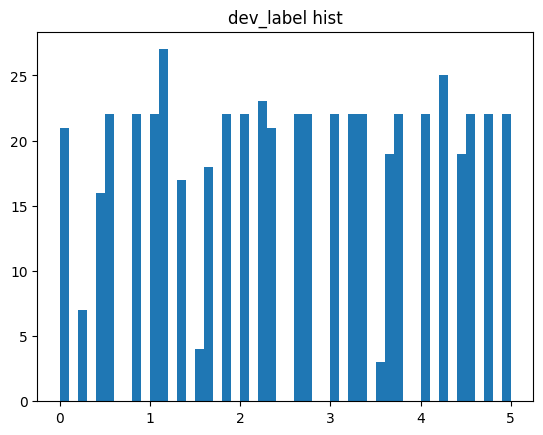

In [13]:
#train과 dev의 label의 분포를 histogram으로 그림
plt.hist(train_label_list, bins=50)
plt.title("train_label hist")
plt.show()

plt.hist(dev_label_list, bins=50)
plt.title("dev_label hist")
plt.show()

***2. 텍스트 길이 분석***

문장의 길이(단어 수나 문자 수)를 분석하여 데이터 셋의 특성을 파악.

너무 긴 문장이나 짧은 문장이 있을 경우, 이를 처리하는 전략을 고려.

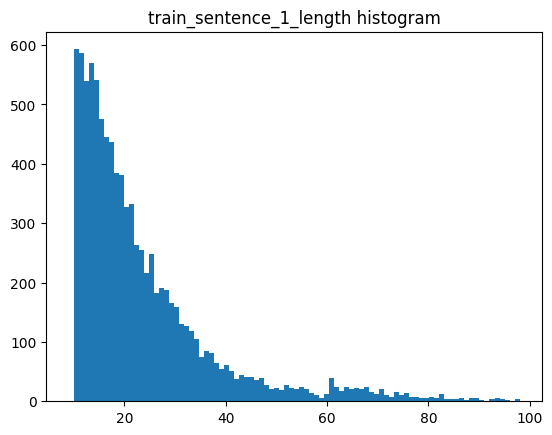

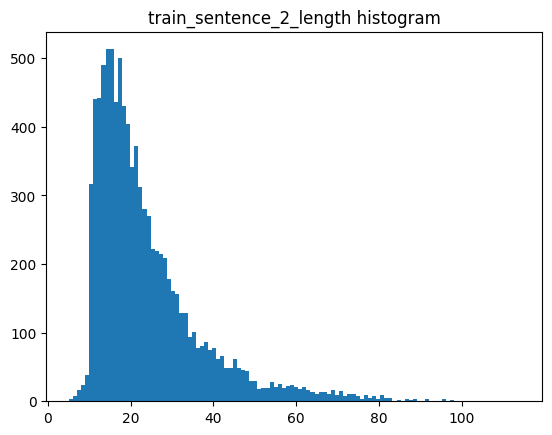

In [14]:
train_sentence_1_length = [ len(row['sentence_1']) for idx, row in train_df.iterrows()  ]
train_sentence_2_length = [ len(row['sentence_2']) for idx, row in train_df.iterrows()  ]

plt.hist(train_sentence_1_length, bins=90)
plt.title("train_sentence_1_length histogram")
plt.show()

plt.hist(train_sentence_2_length, bins=110)
plt.title("train_sentence_2_length histogram")
plt.show()

In [15]:
#train 각 sentence길이 들의 통계분석
print(pd.DataFrame(train_sentence_1_length).describe())
print(pd.DataFrame(train_sentence_2_length).describe())

                 0
count  9324.000000
mean     23.258151
std      14.395189
min       9.000000
25%      14.000000
50%      19.000000
75%      28.000000
max      98.000000
                 0
count  9324.000000
mean     23.726405
std      13.385380
min       5.000000
25%      15.000000
50%      20.000000
75%      28.000000
max     114.000000


In [16]:
#단어갯수 분석
tokenizer = AutoTokenizer.from_pretrained('klue/roberta-large')

train_sentence_1_words_cnt = [ len(tokenizer(row['sentence_1'])['input_ids']) for idx, row in train_df.iterrows() ]
train_sentence_2_words_cnt = [ len(tokenizer(row['sentence_2'])['input_ids']) for idx, row in train_df.iterrows() ]

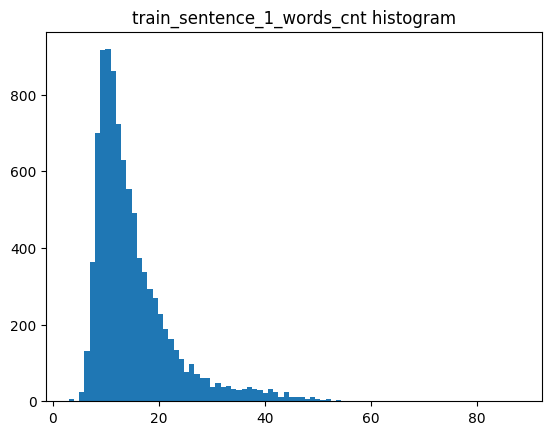

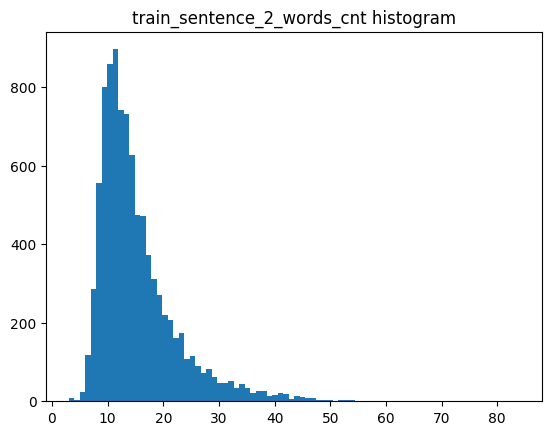

In [17]:
plt.hist(train_sentence_1_words_cnt, bins=86)
plt.title("train_sentence_1_words_cnt histogram")
plt.show()

plt.hist(train_sentence_2_words_cnt, bins=82)
plt.title("train_sentence_2_words_cnt histogram")
plt.show()

In [18]:
#train 각 단어개수 들의 통계분석
print(pd.DataFrame(train_sentence_1_words_cnt).describe())
print(pd.DataFrame(train_sentence_2_words_cnt).describe())

                 0
count  9324.000000
mean     14.848241
std       7.771558
min       3.000000
25%      10.000000
50%      13.000000
75%      17.000000
max      88.000000
                 0
count  9324.000000
mean     14.958387
std       7.201888
min       3.000000
25%      10.000000
50%      13.000000
75%      18.000000
max      84.000000


***3. 유사도 레이블과의 관계 분석***

유사도 레이블과 다른 특성(예: 문장 길이 차이, 같은 단어 사용 빈도, BLEU score 등) 사이의 관계를 분석.

이를 통해 어떤 특성이 유사도 판단에 영향을 미치는지 이해.

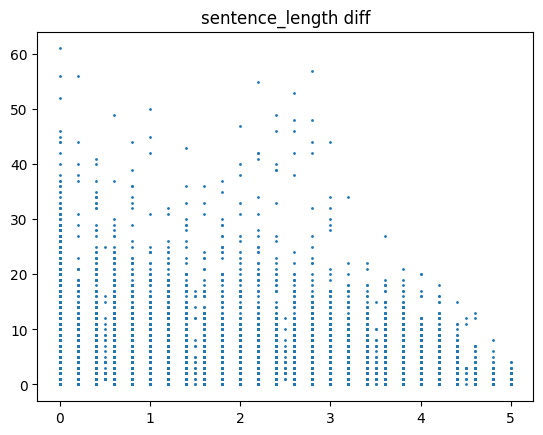

In [19]:
#label에 따른 문장길이 차이
diff_between_two_sent = {'difference':[], 'label':[]}

for idx, row in train_df.iterrows():
    diff = abs( len(row['sentence_1'])-len(row['sentence_2']) )
    diff_between_two_sent['difference'].append(diff)
    diff_between_two_sent['label'].append(row['label'])

plt.scatter(diff_between_two_sent['label'],
            diff_between_two_sent['difference'], s = 1)
plt.title("sentence_length diff")
plt.show()

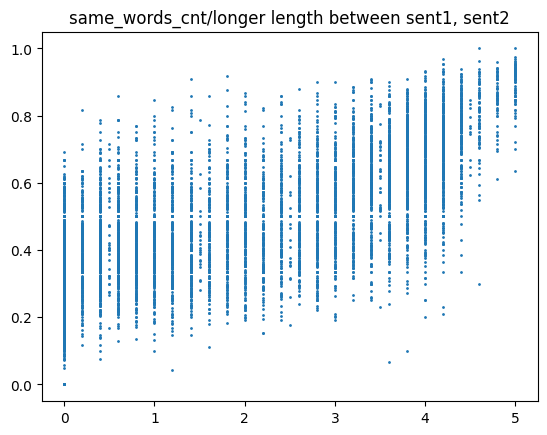

In [20]:
#label에 따른 같은단어빈도수/긴 단어길이
from collections import Counter

same_words_cnt = {'cnt':[], 'label':[]}

for idx, row in train_df.iterrows():
    sent_1_cnt = Counter(row['sentence_1'])
    sent_2_cnt = Counter(row['sentence_2'])
    inter_counter = sent_1_cnt & sent_2_cnt
    cnt = 0
    for key, value in inter_counter.items():
        cnt += value
    same_words_cnt['cnt'].append(cnt/max(len(row['sentence_1']),len(row['sentence_2'])))
    same_words_cnt['label'].append(row['label'])

plt.scatter(same_words_cnt['label'],
            same_words_cnt['cnt'], s = 1)
plt.title("same_words_cnt/longer length between sent1, sent2")
plt.show()

***4. 구성 분석***

가장 흔하게 사용되는 단어, 특정 단어들이 함께 사용되는 패턴, 문장의 구성 등을 분석.

이를 통해 데이터셋의 언어적 특성을 파악.

In [21]:
import nltk
from nltk.util import ngrams

In [22]:
# n-gram score
n_gram_score = {'score_1':[], 'score_2':[], 'score_3':[], 'label':[]}

def n_gram(n, sent_1, sent_2):
    sent_1_cnt = Counter(list(ngrams(sent_1, n)))
    sent_2_cnt = Counter(list(ngrams(sent_1, n)))
    inter = sent_1_cnt & sent_2_cnt
    cnt = 0
    for key, value in inter.items():
        cnt += value

    return cnt / max(len(sent_1), len(sent_2))

for idx, row in train_df.iterrows():
    sent_1 = tokenizer(row['sentence_1'])['input_ids']
    sent_2 = tokenizer(row['sentence_2'])['input_ids']

    score_1 = n_gram(1, sent_1, sent_2)
    score_2 = n_gram(2, sent_1, sent_2)
    score_3 = n_gram(3, sent_1, sent_2)

    n_gram_score['score_1'].append(score_1)
    n_gram_score['score_2'].append(score_2)
    n_gram_score['score_3'].append(score_3)
    n_gram_score['label'].append(row['label'])

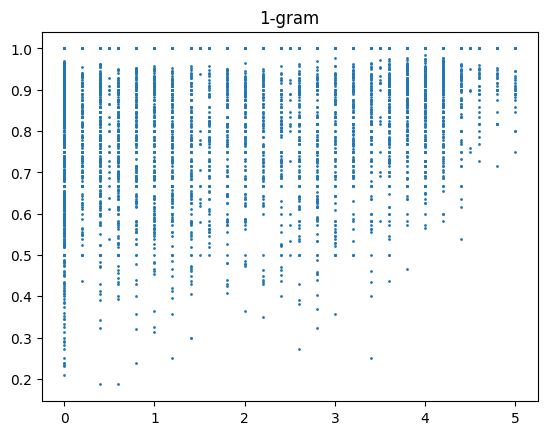

In [23]:
# 1-gram
plt.scatter(n_gram_score['label'],
            n_gram_score['score_1'], s = 1)
plt.title("1-gram")
plt.show()

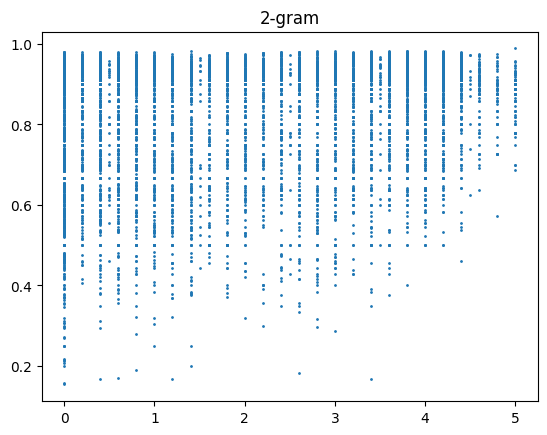

In [24]:
# 2-gram
plt.scatter(n_gram_score['label'],
            n_gram_score['score_2'], s = 1)
plt.title("2-gram")
plt.show()

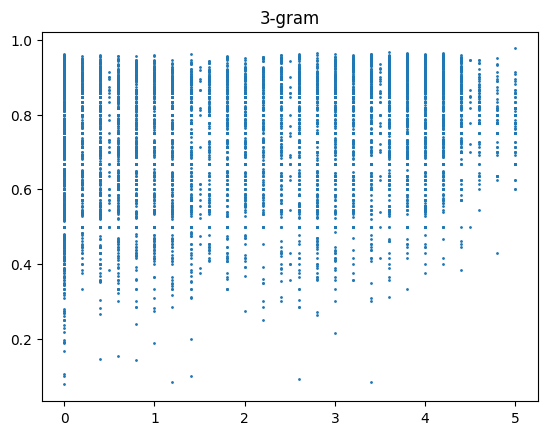

In [25]:
# 3-gram
plt.scatter(n_gram_score['label'],
            n_gram_score['score_3'], s = 1)
plt.title("3-gram")
plt.show()

In [26]:
# BLEU score

In [27]:
def BLEU_score(sent_1, sent_2):
    sent_1_n_gram = {'1-gram':Counter(list(ngrams(sent_1, 1))),
                     '2-gram':Counter(list(ngrams(sent_1, 2))),
                     '3-gram':Counter(list(ngrams(sent_1, 3)))}
    sent_2_n_gram = {'1-gram':Counter(list(ngrams(sent_2, 1))),
                     '2-gram':Counter(list(ngrams(sent_2, 2))),
                     '3-gram':Counter(list(ngrams(sent_2, 3)))}
    inter = {'1-gram': sent_1_n_gram['1-gram'] & sent_2_n_gram['1-gram'],
             '2-gram': sent_1_n_gram['2-gram'] & sent_2_n_gram['2-gram'],
             '3-gram': sent_1_n_gram['3-gram'] & sent_2_n_gram['3-gram']}

    sent_1_n_gram_cnt = [sum(sent_1_n_gram['1-gram'].values()),
                         sum(sent_1_n_gram['2-gram'].values()),
                         sum(sent_1_n_gram['3-gram'].values())]
    sent_2_n_gram_cnt = [sum(sent_2_n_gram['1-gram'].values()),
                         sum(sent_2_n_gram['2-gram'].values()),
                         sum(sent_2_n_gram['3-gram'].values())]
    inter_cnt = [sum(inter['1-gram'].values()),
                 sum(inter['2-gram'].values()),
                 sum(inter['3-gram'].values())]

    res = min(sent_1_n_gram_cnt[0], sent_2_n_gram_cnt[0]) / max(sent_1_n_gram_cnt[0], sent_2_n_gram_cnt[0])

    for i in range(3):
        res *= ( inter_cnt[i] / min(sent_1_n_gram_cnt[i], sent_2_n_gram_cnt[i]) )

    return res


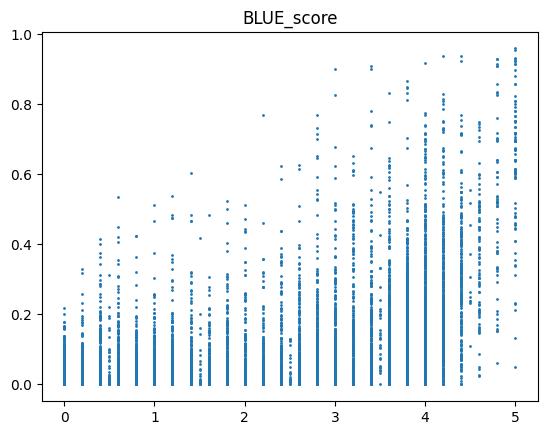

In [29]:
bleu_score = {'BLEU':[], 'label':[]}

for idx, row in train_df.iterrows():
    bleu = BLEU_score(row['sentence_1'], row['sentence_2'])
    bleu_score['BLEU'].append(bleu)
    bleu_score['label'].append(row['label'])

plt.scatter(bleu_score['label'],
            bleu_score['BLEU'], s = 1)
plt.title("BLUE_score")
plt.show()